## Introduction

Text Classification can be used to solve various use-cases like sentiment analysis, spam detection, hashtag prediction etc. This notebook demonstrates the use of SageMaker BlazingText to perform supervised binary/multi class with single or multi label text classification. BlazingText can train the model on more than a billion words in a couple of minutes using a multi-core CPU or a GPU, while achieving performance on par with the state-of-the-art deep learning text classification algorithms. BlazingText extends the fastText text classifier to leverage GPU acceleration using custom CUDA kernels.

## Setup

Let's start by specifying:

- The S3 bucket and prefix that you want to use for training and model data. This should be within the same region as the Notebook Instance, training, and hosting. If you don't specify a bucket, SageMaker SDK will create a default bucket following a pre-defined naming convention in the same region. 
- The IAM role ARN used to give SageMaker access to your data. It can be fetched using the **get_execution_role** method from sagemaker python SDK.

In [1]:
import sagemaker
from sagemaker import get_execution_role
import json
import boto3
import nltk
sess = sagemaker.Session()

role = get_execution_role()
print(
    role
)  # This is the role that SageMaker would use to leverage AWS resources (S3, CloudWatch) on your behalf

bucket = 'inox-icm-bt'  # Replace with your own bucket name if needed
print(bucket)
prefix = "blazingtext/prdrc/supervised"  # Replace with the prefix under which you want to store the data if needed

arn:aws:iam::430758128697:role/service-role/AmazonSageMaker-ExecutionRole-20220308T183116
inox-icm-bt


### Data Preparation

Now we'll download a dataset from the web on which we want to train the text classification model. BlazingText expects a single preprocessed text file with space separated tokens and each line of the file should contain a single sentence and the corresponding label(s) prefixed by "\__label\__".

In this example, let us train the text classification model on the [DBPedia Ontology Dataset](https://wiki.dbpedia.org/services-resources/dbpedia-data-set-2014#2) as done by [Zhang et al](https://arxiv.org/pdf/1500009.01626.pdf). The DBpedia ontology dataset is constructed by picking 14 nonoverlapping classes from DBpedia 2014. It has 500060,000 training samples and 70,000 testing samples. The fields we used for this dataset contain title and abstract of each Wikipedia article. 

In [2]:
import pandas as pd
import numpy as np
import glob
import os
import boto3

In [3]:
pd.set_option("display.max_colwidth", -1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


In [83]:
# df = pd.read_excel(open("Final Consolidated Ryan Mapping.xlsx","rb"),sheet_name="Consolidated",engine='openpyxl')
train = pd.read_csv("prdrc_data_balanced_train.csv")
test = pd.read_csv("prdrc_data_not_balanced_test.csv")

In [84]:
train = pd.concat([train,test],axis = 0)

In [85]:
train.head(4)

,item_name,SubCat,label
0,"ASUS ZenScreen MB16AH Portable Monitor - Country variant United Kingdom Product type Desktop monitor Display size 39.6 cm (15.6"") Physical resolution 1920 x 1080 FHD Aspect ratio 16 9 Contrast 700 1 Brightness 220cd/mÂ² Pane",COMPUTER MONITOR,Non-DRC
1,2021-IT:Brand Safety:Double Verifty:ATL-Brand Safety,OTHER,Non-DRC
2,CART PICK 2-TOTES,OTHER,Non-DRC
3,"ASUS ZenScreen MB16ACE Portable Monitor - Country variant United Kingdom Product type Desktop monitor Display size 39.6 cm (15.6"") Physical resolution 1920 x 1080 FHD Aspect ratio 16 9 Contrast 800 1 Brightness 250cd/mÂ² Pan",COMPUTER MONITOR,Non-DRC


In [86]:
train.shape

(259735, 3)

In [87]:
train.columns

Index(['item_name', 'SubCat', 'label'], dtype='object')

In [88]:
# we need to reshuffle the dataframe
train = train.sample(frac = 1)

In [89]:
train.head(3)

,item_name,SubCat,label
135958,COMMANDER BOOK CASE CURVE FOR APPLE IPHONE 11 PRO SOFT TOUCH GREEN,CASES,Non-DRC
179066,"MICKI LUNDBY DOLLS HOUSE FURNITURE BEDROOM ACCESSORIES – 10-PIECES DOLL HOUSE FURNITURE, DOLL BED, FOR 11CM DOLLS, AGES 4+, SCALE 1:18",140 DOLL HOUSES / FURNITURE,Non-DRC
186852,"ULTIMATE GUARD UGD10807 PROTECTIVE SUPREME UX SLEEVES BRAUN CARD GAME, ORANGE, STANDARD SIZE",335 TRADING CARDS & ACCESSORIES,Non-DRC


In [90]:
train.label.value_counts()

Non-DRC        186430
DRC_Laptop     24684 
DRC_Chip       17738 
DRC_Mobile     14919 
DRC_Tablet     9499  
DRC_PC         4978  
DRC_Console    1487  
Name: label, dtype: int64

In [91]:
# Checking for Duplicate rows
train.shape

(259735, 3)

In [92]:
### Dropping Duplicate rows
train = train.drop_duplicates(subset = ['item_name', 'label']).reset_index(drop = True)
train.shape

(259728, 3)

In [93]:
train.label.value_counts()

Non-DRC        186430
DRC_Laptop     24680 
DRC_Chip       17738 
DRC_Mobile     14918 
DRC_Tablet     9499  
DRC_PC         4978  
DRC_Console    1485  
Name: label, dtype: int64

# Preprocessing the text

#### Feature Engineering FE

Let's calculate number ofletters for each row.

In [94]:
train.head(2)

,item_name,SubCat,label
0,COMMANDER BOOK CASE CURVE FOR APPLE IPHONE 11 PRO SOFT TOUCH GREEN,CASES,Non-DRC
1,"MICKI LUNDBY DOLLS HOUSE FURNITURE BEDROOM ACCESSORIES – 10-PIECES DOLL HOUSE FURNITURE, DOLL BED, FOR 11CM DOLLS, AGES 4+, SCALE 1:18",140 DOLL HOUSES / FURNITURE,Non-DRC


In [95]:
train["word_count"] = train["item_name"].apply(lambda x: len(x))
train.head()

,item_name,SubCat,label,word_count
0,COMMANDER BOOK CASE CURVE FOR APPLE IPHONE 11 PRO SOFT TOUCH GREEN,CASES,Non-DRC,66
1,"MICKI LUNDBY DOLLS HOUSE FURNITURE BEDROOM ACCESSORIES – 10-PIECES DOLL HOUSE FURNITURE, DOLL BED, FOR 11CM DOLLS, AGES 4+, SCALE 1:18",140 DOLL HOUSES / FURNITURE,Non-DRC,134
2,"ULTIMATE GUARD UGD10807 PROTECTIVE SUPREME UX SLEEVES BRAUN CARD GAME, ORANGE, STANDARD SIZE",335 TRADING CARDS & ACCESSORIES,Non-DRC,92
3,"BELKIN BSV400VF2M - OVERCURRENT PROTECTION UP TO 525 JOULES WITH 4 SOCKETS, 2 M CABLE, WHITE / GRAY",CABLES,Non-DRC,99
4,"['APPLE IPAD AIR (10.5 "", WI-FI + MOBILE, 64GB) - GOLD (PREDECESSOR MODEL)']",TABLET COMPUTERS APPLE,DRC_Tablet,76


Let's get basic statistics about the dataset.

In [96]:
stat=dict(train["word_count"].describe())
stat

{'count': 259728.0,
 'mean': 89.40359914987988,
 'std': 48.9513278592518,
 'min': 1.0,
 '25%': 51.0,
 '50%': 76.0,
 '75%': 121.0,
 'max': 416.0}

In [97]:
Rule_IQR_Range = stat['75%'] + 1.5000 * (stat['75%']-stat['25%'])
print(Rule_IQR_Range)

226.0


We can see that the mean value is around 90 letters. However, there are outliers, such as a text with 98 words. This can make it harder for the model to result in good performance. We will take care to drop those rows.

Let's drop empty rows first.

In [98]:
no_text = train[train["word_count"] < 2]
print(len(no_text))

# drop these rows
train.drop(no_text.index, inplace=True)

2


In [99]:
no_text

,item_name,SubCat,label,word_count
13889,.,ADAPTER,Non-DRC,1
159370,-,COMPUTING PERIPHERALS: OTHER,Non-DRC,1


Let's drop the rows that are longer than min words, as it is a length close to the mean value of the word count. This is done to make it easy for the model to train without outliers. 

In [100]:
# long_text = train[(train["word_count"] > (Rule_IQR_Range+2))]
# print(len(long_text))

# # drop these rows
# train.drop(long_text.index, inplace=True)

In [101]:
train["label"].value_counts()

Non-DRC        186428
DRC_Laptop     24680 
DRC_Chip       17738 
DRC_Mobile     14918 
DRC_Tablet     9499  
DRC_PC         4978  
DRC_Console    1485  
Name: label, dtype: int64

Let's get basic statistics about the dataset after our outliers fixes.

In [102]:
# train["word_count"].describe()

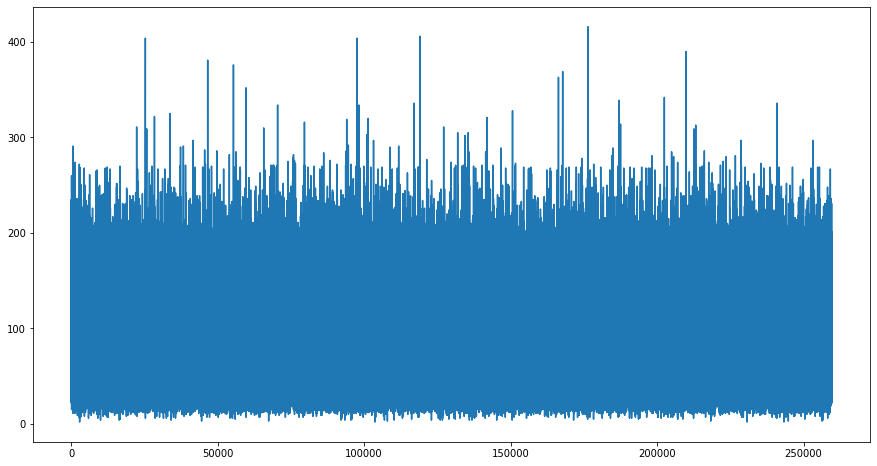

In [103]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize = (15,8))
train["word_count"].plot()

This looks much more balanced.

Now we drop the `word_count` columns as we will not need it anymore.

In [26]:
train.drop(columns="word_count", axis=1, inplace=True)

In [27]:
train.head(3)

,item_name,SubCat,label
0,"LENOVO LEGION 5-15ARH 15.6"" FHD GAMING LAPTOPY (AMD RYZEN 7 4800H, NVIDIA GEFORCE GTX 1650 4GB, 8GB RAM, 256GB SSD, DOS, BACKLIT KEYBOARD) PHANTOM CZARNY (82B500AKPB) QWERTY",CONSUMER NOTEBOOKS AMD,DRC_Laptop
1,"SMARTPHONE HUAWEI NEW 5T - 6TH ""(6 GB RAM, 128 GB, PHOTOCAMATER AFISPAY, FULLVIEW, 3750 MAH) DUUAL-SIM, COLOR VIOLET",SMART PHONE,DRC_Mobile
2,"APPROX APPSPK 2.0 SPEAKERS - SELF-REINFORCING - 30 W + 30 W - INPUT 2 X CINCH - REAR CONTROLS - WALL MOUNT - IDEAL FOR PI, WHITE",AUDIO SPEAKERS,Non-DRC


In [28]:
train = train.drop("SubCat",axis=1)
test = test.drop("SubCat",axis=1)

In [29]:
test.label.value_counts(),test.shape

(Non-DRC        20710
 DRC_Laptop     1165 
 DRC_Mobile     1041 
 DRC_Chip       675  
 DRC_PC         184  
 DRC_Tablet     175  
 DRC_Console    53   
 Name: label, dtype: int64,
 (24003, 2))

In [30]:
train.label.value_counts(),train.shape

(Non-DRC        186428
 DRC_Laptop     24680 
 DRC_Chip       17738 
 DRC_Mobile     14918 
 DRC_Tablet     9499  
 DRC_PC         4978  
 DRC_Console    1485  
 Name: label, dtype: int64,
 (259726, 2))

In [31]:
train.head(2)

,item_name,label
0,"LENOVO LEGION 5-15ARH 15.6"" FHD GAMING LAPTOPY (AMD RYZEN 7 4800H, NVIDIA GEFORCE GTX 1650 4GB, 8GB RAM, 256GB SSD, DOS, BACKLIT KEYBOARD) PHANTOM CZARNY (82B500AKPB) QWERTY",DRC_Laptop
1,"SMARTPHONE HUAWEI NEW 5T - 6TH ""(6 GB RAM, 128 GB, PHOTOCAMATER AFISPAY, FULLVIEW, 3750 MAH) DUUAL-SIM, COLOR VIOLET",DRC_Mobile


In [32]:
train.shape

(259726, 2)

In [33]:
test.head(3)

,item_name,label
0,"RELAXDAYS 10025180 SUN PINATA, HANGING CHILDREN’S PAPER PIÑATA FOR BOYS & GIRLS, FILLABLE, BIRTHDAY DECORATION, UNISEX, YELLOW/ORANGE",Non-DRC
1,MICKEY MOUSE HAPPY SAMSUNG GALAXY A5 2017 SILICONE,Non-DRC
2,INJUSTICE: GODS AMONG US ULTIMATE EDITION (PC DVD) [UK IMPORT],Non-DRC


In [34]:
!mkdir -p data
train.to_csv("./data/train.csv",index=False)
test.to_csv("./data/test.csv",index=False)

The `transform_instance` will be applied to each data instance in parallel using python's multiprocessing module

In [35]:
%%time
import preprocessing_prdrc
# Preparing the training dataset
preprocessing_prdrc.preprocess("data/train.csv", "icm.train")

# Preparing the validation dataset
preprocessing_prdrc.preprocess("data/test.csv", "icm.validation")

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


CPU times: user 2min 27s, sys: 622 ms, total: 2min 28s
Wall time: 2min 42s


The data preprocessing cell might take a minute to run. After the data preprocessing is complete, we need to upload it to S3 so that it can be consumed by SageMaker to execute training jobs. We'll use Python SDK to upload these two files to the bucket and prefix location that we have set above.   

In [36]:
%%time

train_channel = prefix + "/train"
validation_channel = prefix + "/validation"

sess.upload_data(path="icm.train", bucket=bucket, key_prefix=train_channel)
sess.upload_data(path="icm.validation", bucket=bucket, key_prefix=validation_channel)

s3_train_data = "s3://{}/{}".format(bucket, train_channel)
s3_validation_data = "s3://{}/{}".format(bucket, validation_channel)

CPU times: user 213 ms, sys: 95.9 ms, total: 309 ms
Wall time: 1.34 s


Next we need to setup an output location at S3, where the model artifact will be dumped. These artifacts are also the output of the algorithm's traning job.

In [37]:
s3_output_location = "s3://{}/{}/output".format(bucket, prefix)

## Training
Now that we are done with all the setup that is needed, we are ready to train our object detector. To begin, let us create a ``sageMaker.estimator.Estimator`` object. This estimator will launch the training job.

In [38]:
region_name = boto3.Session().region_name

In [39]:
container = sagemaker.amazon.amazon_estimator.get_image_uri(region_name, "blazingtext", "latest")
print("Using SageMaker BlazingText container: {} ({})".format(container, region_name))

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: latest.


Using SageMaker BlazingText container: 433757028032.dkr.ecr.us-west-2.amazonaws.com/blazingtext:1 (us-west-2)


## Training the BlazingText model for supervised text classification

Similar to the original implementation of [Word2Vec](https://arxiv.org/pdf/1301.3781.pdf), SageMaker BlazingText provides an efficient implementation of the continuous bag-of-words (CBOW) and skip-gram architectures using Negative Sampling, on CPUs and additionally on GPU[s]. The GPU implementation uses highly optimized CUDA kernels. To learn more, please refer to [*BlazingText: Scaling and Accelerating Word2Vec using Multiple GPUs*](https://dl.acm.org/citation.cfm?doid=3146347.3146350004).




Besides skip-gram and CBOW, SageMaker BlazingText also supports the "Batch Skipgram" mode, which uses efficient mini-batching and matrix-matrix operations ([BLAS Level 3 routines](https://software.intel.com/en-us/mkl-developer-reference-fortran-blas-level-3-routines)). This mode enables distributed word2vec training across multiple CPU nodes, allowing almost linear scale up of word2vec computation to process hundreds of millions of words per second. Please refer to [*Parallelizing Word2Vec in Shared and Distributed Memory*](https://arxiv.org/pdf/1604.04661.pdf) to learn more.

BlazingText also supports a *supervised* mode for text classification. It extends the FastText text classifier to leverage GPU acceleration using custom CUDA kernels. The model can be trained on more than a billion words in a couple of minutes using a multi-core CPU or a GPU, while achieving performance on par with the state-of-the-art deep learning text classification algorithms. For more information, please refer to the [algorithm documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/blazingtext.html).

To summarize, the following modes are supported by BlazingText on different types instances:

|          Modes         	| cbow (supports subwords training) 	| skipgram (supports subwords training) 	| batch_skipgram 	| supervised |
|:----------------------:	|:----:	|:--------:	|:--------------:	| :--------------:	|
|   Single CPU instance  	|   ✔  	|     ✔    	|        ✔       	|  ✔  |
|   Single GPU instance  	|   ✔  	|     ✔    	|                	|  ✔ (Instance with 1 GPU only)  |
| Multiple CPU instances 	|      	|          	|        ✔       	|     | |

Now, let's define the SageMaker `Estimator` with resource configurations and hyperparameters to train Text Classification on *DBPedia* dataset, using "supervised" mode on a `c4.4xlarge` instance.

Refer to [BlazingText Hyperparameters](https://docs.aws.amazon.com/sagemaker/latest/dg/blazingtext_hyperparameters.html) in the Amazon SageMaker documentation for the complete list of hyperparameters.

In [38]:
bt_model = sagemaker.estimator.Estimator(
    container,
    role,
    instance_count=1,
    instance_type="ml.c4.4xlarge",
    volume_size=30,
#     max_run=360000,
    input_mode="File",
    output_path=s3_output_location,
    hyperparameters={
        "mode": "supervised",
        "epochs": 7,
#         "min_count": 2,
        "learning_rate": 0.12,
#         "vector_dim": 10,
#         "early_stopping": True,
#         "patience": 4,
        "min_epochs": 5,
        "word_ngrams": 2,
    },
)

In [39]:
# Auto tune
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

hyperparameter_ranges = {
    "epochs": IntegerParameter(10,40),
#     "batch_size": IntegerParameter(8,32),
    "learning_rate": ContinuousParameter(0.015, 0.300),
#     "window_size": IntegerParameter(1, 10),
    "word_ngrams": IntegerParameter(1,2),
#     "buckets": IntegerParameter(1000000,10000000),
#     "min_count": IntegerParameter(1,100)
}

objective_metric_name = "validation:accuracy"
objective_type = "Maximize"

tuner = HyperparameterTuner(
    bt_model,
    objective_metric_name,
    hyperparameter_ranges,
    max_jobs=6,
    max_parallel_jobs=2,
    objective_type=objective_type,
)

Now that the hyper-parameters are setup, let us prepare the handshake between our data channels and the algorithm. To do this, we need to create the `sagemaker.session.s3_input` objects from our data channels. These objects are then put in a simple dictionary, which the algorithm consumes.

In [44]:
train_data = sagemaker.inputs.TrainingInput(
    s3_train_data,
    distribution="FullyReplicated",
    content_type="text/plain",
    s3_data_type="S3Prefix",
)
validation_data = sagemaker.inputs.TrainingInput(
    s3_validation_data,
    distribution="FullyReplicated",
    content_type="text/plain",
    s3_data_type="S3Prefix",
)
data_channels = {"train": train_data, "validation": validation_data}

We have our `Estimator` object, we have set the hyper-parameters for this object and we have our data channels linked with the algorithm. The only  remaining thing to do is to train the algorithm. The following command will train the algorithm. Training the algorithm involves a few steps. Firstly, the instance that we requested while creating the `Estimator` classes is provisioned and is setup with the appropriate libraries. Then, the data from our channels are downloaded into the instance. Once this is done, the training job begins. The provisioning and data downloading will take some time, depending on the size of the data. Therefore it might be a few minutes before we start getting training logs for our training jobs. The data logs will also print out Accuracy on the validation data for every epoch after training job has executed `min_epochs`. This metric is a proxy for the quality of the algorithm. 

Once the job has finished a "Job complete" message will be printed. The trained model can be found in the S3 bucket that was setup as `output_path` in the estimator.

### Launch hyperparameter tuning job

Now we can launch a hyperparameter tuning job by calling fit() function. After the hyperparameter tuning job is created, we can go to SageMaker console to track the progress of the hyperparameter tuning job until it is completed.

This should take around 12 minutes to complete.


In [41]:
%%time

tuner.fit(inputs=data_channels, logs=True)

........................................................................................................................................!
CPU times: user 499 ms, sys: 47.6 ms, total: 547 ms
Wall time: 11min 27s



### Analyze Results of a Hyperparameter Tuning job

Once you have completed a tuning job, (or even while the job is still running) you can use the code below to analyze the results to understand how each hyperparameter effects the quality of the model.


In [42]:
sm_client = boto3.Session().client("sagemaker")

tuning_job_name = tuner.latest_tuning_job.name
tuning_job_name

'blazingtext-220601-1954'

### Track hyperparameter tuning job progress

After you launch a tuning job, you can see its progress by calling describe_tuning_job API. The output from describe-tuning-job is a JSON object that contains information about the current state of the tuning job. You can call list_training_jobs_for_tuning_job to see a detailed list of the training jobs that the tuning job launched.

In [43]:
tuning_job_result = sm_client.describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuning_job_name
)

status = tuning_job_result["HyperParameterTuningJobStatus"]
if status != "Completed":
    print("Reminder: the tuning job has not been completed.")

job_count = tuning_job_result["TrainingJobStatusCounters"]["Completed"]
print("%d training jobs have completed" % job_count)

is_minimize = (
    tuning_job_result["HyperParameterTuningJobConfig"]["HyperParameterTuningJobObjective"]["Type"]
    != "Maximize"
)
objective_name = tuning_job_result["HyperParameterTuningJobConfig"][
    "HyperParameterTuningJobObjective"
]["MetricName"]

6 training jobs have completed


In [44]:
from pprint import pprint

if tuning_job_result.get("BestTrainingJob", None):
    print("Best model found so far:")
    pprint(tuning_job_result["BestTrainingJob"])
else:
    print("No training jobs have reported results yet.")

Best model found so far:
{'CreationTime': datetime.datetime(2022, 6, 1, 19, 54, 37, tzinfo=tzlocal()),
 'FinalHyperParameterTuningJobObjectiveMetric': {'MetricName': 'validation:accuracy',
                                                 'Value': 0.9901000261306763},
 'ObjectiveStatus': 'Succeeded',
 'TrainingEndTime': datetime.datetime(2022, 6, 1, 19, 59, 4, tzinfo=tzlocal()),
 'TrainingJobArn': 'arn:aws:sagemaker:us-west-2:430758128697:training-job/blazingtext-220601-1954-001-e226ee20',
 'TrainingJobName': 'blazingtext-220601-1954-001-e226ee20',
 'TrainingJobStatus': 'Completed',
 'TrainingStartTime': datetime.datetime(2022, 6, 1, 19, 56, 23, tzinfo=tzlocal()),
 'TunedHyperParameters': {'epochs': '24',
                          'learning_rate': '0.24161930379055385',
                          'word_ngrams': '2'}}


#### We can list hyperparameters and objective metrics of all training jobs and pick up the training job with the best objective metric.

In [45]:
import pandas as pd

tuner_analytics = sagemaker.HyperparameterTuningJobAnalytics(tuning_job_name)

full_df = tuner_analytics.dataframe()

if len(full_df) > 0:
    df = full_df[full_df["FinalObjectiveValue"] > -float("inf")]
    if len(df) > 0:
        df = df.sort_values("FinalObjectiveValue", ascending=is_minimize)
        print("Number of training jobs with valid objective: %d" % len(df))
        print({"lowest": min(df["FinalObjectiveValue"]), "highest": max(df["FinalObjectiveValue"])})
        pd.set_option("display.max_colwidth", -1)  # Don't truncate TrainingJobName
    else:
        print("No training jobs have reported valid results yet.")

df

Number of training jobs with valid objective: 6
{'lowest': 0.9868999719619751, 'highest': 0.9901000261306763}


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  del sys.path[0]


,epochs,learning_rate,word_ngrams,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
4,40.0,0.149635,2.0,blazingtext-220601-1954-002-df33b619,Completed,0.9901,2022-06-01 19:56:08+00:00,2022-06-01 19:58:51+00:00,163.0
5,24.0,0.241619,2.0,blazingtext-220601-1954-001-e226ee20,Completed,0.9901,2022-06-01 19:56:23+00:00,2022-06-01 19:59:04+00:00,161.0
0,13.0,0.020046,2.0,blazingtext-220601-1954-006-d9728ab6,Completed,0.9896,2022-06-01 20:03:34+00:00,2022-06-01 20:05:51+00:00,137.0
3,12.0,0.023285,1.0,blazingtext-220601-1954-003-bb849e00,Completed,0.9885,2022-06-01 20:00:26+00:00,2022-06-01 20:01:09+00:00,43.0
2,10.0,0.141855,1.0,blazingtext-220601-1954-004-741b106d,Completed,0.9883,2022-06-01 20:00:50+00:00,2022-06-01 20:01:37+00:00,47.0
1,39.0,0.235457,1.0,blazingtext-220601-1954-005-2f731fe8,Completed,0.9869,2022-06-01 20:02:51+00:00,2022-06-01 20:03:38+00:00,47.0


In [45]:
bt_model = sagemaker.estimator.Estimator(
    container,
    role,
    instance_count=1,
    instance_type="ml.c4.4xlarge",
    volume_size=30,
#     max_run=360000,
    input_mode="File",
    output_path=s3_output_location,
    hyperparameters={
        "mode": "supervised",
        "epochs": 24,
#         "min_count": 2,
        "learning_rate": 0.24161930379055385,
#         "vector_dim": 10,
#         "early_stopping": True,
#         "patience": 4,
        "min_epochs": 5,
        "word_ngrams": 2,
    },
)

In [46]:
%%time
bt_model.fit(inputs=data_channels, logs=True)

2022-06-01 21:02:20 Starting - Starting the training job...ProfilerReport-1654117340: InProgress
...
2022-06-01 21:03:08 Starting - Preparing the instances for training......
2022-06-01 21:04:20 Downloading - Downloading input data...
2022-06-01 21:04:44 Training - Downloading the training image..Arguments: train
[06/01/2022 21:04:55 WARNING 140202354546496] Loggers have already been setup.
[06/01/2022 21:04:55 WARNING 140202354546496] Loggers have already been setup.
[06/01/2022 21:04:55 INFO 140202354546496] nvidia-smi took: 0.025225400924682617 secs to identify 0 gpus
[06/01/2022 21:04:55 INFO 140202354546496] Running single machine CPU BlazingText training using supervised mode.
Number of CPU sockets found in instance is  1
[06/01/2022 21:04:55 INFO 140202354546496] Processing /opt/ml/input/data/train/icm.train . File size: 24.411633491516113 MB
[06/01/2022 21:04:55 INFO 140202354546496] Processing /opt/ml/input/data/validation/icm.validation . File size: 2.1626720428466797 MB
Read

### Deploy the best trained model

Once the training is done, we can deploy the trained model as an Amazon SageMaker real-time hosted endpoint. This will allow us to make predictions (or inference) from the model. Note that we don't have to host on the same type of instance that we used to train, because usually for inference, less compute power is needed than for training, and in addition, instance endpoints will be up and running for long, it's advisable to choose a cheaper instance for inference.

    ml.c4.4xlarge - Compute Optimized instances are ideal for compute bound applications that benefit from high performance processors.
    ml.m4.xlarge - General purpose instances provide a balance of compute, memory and networking resources, and can be used for a variety of diverse workloads.



In [47]:
from sagemaker.serializers import JSONSerializer

# text_classifier = tuner.deploy(
#     initial_instance_count=1, instance_type="ml.m4.xlarge", serializer=JSONSerializer()
# )
text_classifier = bt_model.deploy(
    initial_instance_count=1, instance_type="ml.m4.xlarge", serializer=JSONSerializer()
)

-------!

## Hosting / Inference
Once the training is done, we can deploy the trained model as an Amazon SageMaker real-time hosted endpoint. This will allow us to make predictions (or inference) from the model. Note that we don't have to host on the same type of instance that we used to train. Because instance endpoints will be up and running for long, it's advisable to choose a cheaper instance for inference.

#### Use JSON format for inference
BlazingText supports `application/json` as the content-type for inference. The payload should contain a list of sentences with the key as "**instances**" while being passed to the endpoint.

In [48]:
sentences = [
"ALIENWARE 15000 R3 2.8GHZ I7-7700HQ INTEL® CORET I7 OF SEVENTH GENERATION 15000.6 ""1920 X 1080PIXEL SILVER LAPTOP",
"ACER LIQUID Z6 E DUAL MICRO SIM SMARTPHONE (12.7 CM (5000 INCH) HD DISPLAY, 8GB MEMORY, 2,000MAH BATTERY, ANDROID 6.0) BLACK",
"APPLE JUICE/FRUIT",
"APPLE IPHONE 11 (128GB) - BLACK (INCLUDES EARPODS, POWER ADAPTER)",
"APPLE CHARGER",
"Apple watch (12GB) BLACK (INCLUDES EARPODS, POWER ADAPTER)"
]
sentences = preprocessing_prdrc.preprocess_line(sentences)
payload = {"instances": sentences, "configuration": {"k": 1}}

response = text_classifier.predict(payload)

predictions = json.loads(response)
# print(json.dumps(predictions, indent=2))
listed = []
for i in predictions:
    listed.append({"Intent":i["label"][0][9:],"Intent_confidence":i["prob"][0]*100})

listed

[{'Intent': 'DRC_Laptop', 'Intent_confidence': 99.04639720916748},
 {'Intent': 'DRC_Mobile', 'Intent_confidence': 99.84075427055359},
 {'Intent': 'Non-DRC', 'Intent_confidence': 100.00078678131104},
 {'Intent': 'DRC_Mobile', 'Intent_confidence': 100.00090599060059},
 {'Intent': 'Non-DRC', 'Intent_confidence': 100.00100135803223},
 {'Intent': 'DRC_Mobile', 'Intent_confidence': 71.76913619041443}]

In [50]:
import pandas as pd
df1 = pd.read_excel(open("prdrc-gb-testing-data.xlsx","rb"),engine='openpyxl')

In [68]:
df1.columns

Index(['pc_invoice_id', 'ofa_invoice_id', 'invoice_number', 'invoice_status',
       'ofa_vendor_number', 'ofa_vendor_id', 'ofa_vendor_site_id', 'payee_id',
       'payee_site_id', 'invoice_source', 'source_invoice_type',
       'invoice_type', 'description', 'service_type', 'operational_org',
       'ofa_org', 'bill_to_org', 'ship_to_org', 'bill_to_entity_id',
       'ship_to_entity_id', 'company_name', 'business_type',
       'vendor_account_number', 'service_period_start_date_in_utc',
       'service_period_end_date_in_utc', 'has_cross_border_shipment',
       'amazon_tax_id', 'requesters', 'payment_status', 'payment_type',
       'pc_created_date_invoice_header_in_utc', 'invoicedate',
       'line_item_category', 'description_1', 'locate_prdrc', 'invoice_amount',
       'line_item_deliverable_type', 'line_item_type', 'status', 'substatus',
       'tax_country_code', 'tax', 'tax_id', 'tax_currency', 'tax_exempt_flag',
       'tax_percentage', 'tax_rate_code', 'tax_amount_in_local_cu

In [52]:
sentences = df1.description_1.values.astype(str)
sentences[:10]

array(['Amazon Flex', 'LHR32 - Security 2022 Guard and Star',
       'SALVEQUICK FABRIC PLASTERS',
       'Cisco ISA-3000-2C2F-K9= Firewall - Country variant United Kingdom Product type Firewall Ports 2 x LAN, 2 x SFP VPN Yes WLAN No Industrial Security Appliance 3000 2 x copper 2 x fibre ports Manufacturer s warranty 5-year bring',
       '5 Star Office Hot and Cold A4 Laminator Up to 2x125micron Pouches',
       '500mm wide x 250mm high x 5mm foamex, DOUBLE sided direct printed, c/w x 2 6mm pre-drilled holes & supplied x 2 ceiling tile clips and 150mm hanging brackets',
       'International Womens Day - Books',
       'SBL EU 8 Bin Cage Molex PCB Connection Cable',
       '100-014126-006 RACK, ASH816X12, QUANTA, EU, 1302LBS, 14.4KVA, N+C, 2WHIP, ANYFEED, 3SWX12UP, 100G, SMF, KETTLE',
       'Freight'], dtype='<U255')

In [53]:
## for translation for NON - ENG Datasets
# import numpy as np
# from googletrans import Translator
# translator = Translator()
# translations = []
# for i in range(len(sentences)//5000):
#     print(i)
#     sentence=list(map(str,sentences[(i*5000):((i+1)*5000)]))
#     for j in sentence:
#         translations+=[translator.translate(j, dest='en').text]
# for j in sentences[((i+1)*5000):]:
#     translations+=[translator.translate(j, dest='en').text]
# print("length of translations:",len(translations))
# translations[:10]

In [4]:
%%time
# invoke endpoint
import json
import boto3
import preprocessing_prdrc
sm_runtime = boto3.client("sagemaker-runtime")
sentences_ = [
"ALIENWARE 15 R3 2.8GHZ I7-7700HQ INTEL® CORET I7 OF SEVENTH GENERATION 15.6 ""1920 X 1080PIXEL SILVER LAPTOP",
"ACER LIQUID Z6 E DUAL MICRO SIM SMARTPHONE (12.7 CM (5 INCH) HD DISPLAY, 8GB MEMORY, 2,000MAH BATTERY, ANDROID 6.0) BLACK",
"APPLE JUICE/FRUIT",
"Vending machines (Drinks, Fresh fruit)",
"APPLE IPHONE 11 (128GB) - BLACK (INCLUDES EARPODS, POWER ADAPTER)",
"APPLE Charger",
"Universal charger 12 to 18 volt"]

processed_sentences_ = preprocessing_prdrc.preprocess_line(sentences_)

payload = json.dumps({"instances": processed_sentences_, "configuration": {"k": 1}})
content_type = "application/json"

# respnse type
accept = "text/plain"
endpoint_name = "blazingtext-2022-06-01-21-07-04-634"
res = sm_runtime.invoke_endpoint(
    EndpointName=endpoint_name,
    Body=payload,  # encoded input data
    ContentType=content_type,  # I told the endpoint what's the encode
    Accept=accept,  # I told the endpoint how I want to decode its response
)
predictions = json.loads(res['Body'].read())
# print(json.dumps(predictions, indent=2))
listed = []
for i in predictions:
    listed.append({"Intent":i["label"][0][9:],"Intent_confidence":i["prob"][0]*100})
listed

CPU times: user 17.9 ms, sys: 2.65 ms, total: 20.6 ms
Wall time: 67.8 ms


[{'Intent': 'DRC_Laptop', 'Intent_confidence': 99.99924898147583},
 {'Intent': 'DRC_Mobile', 'Intent_confidence': 99.97391104698181},
 {'Intent': 'Non-DRC', 'Intent_confidence': 100.00078678131104},
 {'Intent': 'Non-DRC', 'Intent_confidence': 100.00100135803223},
 {'Intent': 'DRC_Mobile', 'Intent_confidence': 100.00090599060059},
 {'Intent': 'Non-DRC', 'Intent_confidence': 100.00100135803223},
 {'Intent': 'Non-DRC', 'Intent_confidence': 100.00100135803223}]

In [16]:
## for invoking the endpoint saperately
# import preprocessing_prdrc
# sentence = preprocessing_prdrc.preprocess_line(translations)

# # invoke endpoint
# import json
# sm_runtime = boto3.client("sagemaker-runtime")
# payload = json.dumps({"instances": sentence, "configuration": {"k": 1}})
# content_type = "application/json"

# # respnse type
# accept = "text/plain"
# endpoint_name = "blazingtext-220527-1229-002-039386b8"
# res = sm_runtime.invoke_endpoint(
#     EndpointName=endpoint_name,
#     Body=payload,  # encoded input data
#     ContentType=content_type,  # I told the endpoint what's the encode
#     Accept=accept,  # I told the endpoint how I want to decode its response
# )

# predictions = json.loads(res['Body'].read())
# # print(json.dumps(predictions, indent=2))
# listed = []
# for i in predictions:
#     listed.append({"Intent":i["label"][0][9:],"Intent_confidence":i["prob"][0]*100})

In [56]:
import preprocessing_prdrc
sentence = preprocessing_prdrc.preprocess_line(sentences)

In [60]:
sentence_ = sentence[150000:]

payload = {"instances": sentence_, "configuration": {"k": 1}}

response = text_classifier.predict(payload)

predictions = json.loads(response)
# print(json.dumps(predictions, indent=2))
listed = []
for i in predictions:
    listed.append({"Intent":i["label"][0][9:],"Intent_confidence":i["prob"][0]*100})

In [61]:
# result = []
# confidence = []

for i in range(len(listed)):    
    result.append(listed[i]["Intent"])
    confidence.append(listed[i]["Intent_confidence"])    

In [62]:
sentences.__len__(),len(result)

(304415, 304415)

In [63]:
# df1["translated_sentence"]=translations
df1["model_results"]=result
df1["model_prediction_confidence"]=confidence

In [64]:
df1.model_results.value_counts()

Non-DRC       302280
DRC_Mobile    853   
DRC_Laptop    714   
DRC_Chip      401   
DRC_Tablet    124   
DRC_PC        43    
Name: model_results, dtype: int64

In [65]:
df1.to_csv("GB_prdrc_model_final_predictions.csv")

In [49]:
test

,item_name,label
0,"RELAXDAYS 10025180 SUN PINATA, HANGING CHILDREN’S PAPER PIÑATA FOR BOYS & GIRLS, FILLABLE, BIRTHDAY DECORATION, UNISEX, YELLOW/ORANGE",Non-DRC
1,MICKEY MOUSE HAPPY SAMSUNG GALAXY A5 2017 SILICONE,Non-DRC
2,INJUSTICE: GODS AMONG US ULTIMATE EDITION (PC DVD) [UK IMPORT],Non-DRC
3,"SAMSUNG GALAXY A3 2017 -SMARTPHONE 4.7 ""(OCTA CORE 1.6 GHZ, INTERNAL MEMORY OF 16 GB, 2 GB RAM, 13 MP CAMERA, BLUETOOTH 4.1, ANDROID 6.0)",DRC_Mobile
4,BRODIT 833604 PROCLIP BRACKET,Non-DRC
...,...,...
23998,REVELL 03149 SOVIET BATTLE TANK T-72 M1 MODEL KIT,Non-DRC
23999,JAMARA JAMARA132407 - ELECTRIC MOTOR SUPPORT (330 L),Non-DRC
24000,BRODIT PROCLIP 802223 LEFT CONSOLE MOUNTING BRACKET FOR CIVIC 3&4 DOOR 96-00,Non-DRC
24001,"DEWALT DW033-XJ LASER METER, 30 METERS",Non-DRC


In [50]:
%%time
labels = test.label.to_list()
sentences = preprocessing_prdrc.preprocess_line(test["item_name"].values)
payload = {"instances": sentences, "configuration": {"k": 1}}

response = text_classifier.predict(payload)

predictions_ = json.loads(response)
pred = []
for i in predictions_:
    pred+= [i['label'][0][9:]]    

# print(json.dumps(predictions_, indent=2))

CPU times: user 14.7 s, sys: 15.9 ms, total: 14.7 s
Wall time: 15.3 s


In [51]:
sentences[:10]

['relaxday 10025180 sun pinata hang children ’ s paper piñata for boy girl fillabl birthday decor unisex yellow orang',
 'mickey mous happi samsung galaxi a5 2017 silicon',
 'injustic god among us ultim edit pc dvd uk import',
 'samsung galaxi a3 2017 smartphon 4 7 octa core 1 6 ghz intern memori of 16 gb 2 gb ram 13 mp camera bluetooth 4 1 android 6 0',
 'brodit 833604 proclip bracket',
 'jabra sport puls special edit wireless bluetooth stereo earbud with built in heart rate monitor black',
 'scor src 140 b watch analog black',
 'polycom 1457 52783 002 1 8 m usb on usb b cabl usb',
 'sandisk ultra fit 64 gb usb flash drive usb 3 0 up to 150 mb sek',
 'libraton zip mini 2 smart wireless small speaker alexa integr airplay 2 multiroom 360 ° sound wi fi bluetooth spotifi connect 12 hr batteri cranberri red']

In [52]:
pred.__len__(),test.__len__()

(24003, 24003)

In [53]:
pd.Series(labels).value_counts(),pd.Series(pred).value_counts()

(Non-DRC        20710
 DRC_Laptop     1165 
 DRC_Mobile     1041 
 DRC_Chip       675  
 DRC_PC         184  
 DRC_Tablet     175  
 DRC_Console    53   
 dtype: int64,
 Non-DRC        20684
 DRC_Laptop     1172 
 DRC_Mobile     1035 
 DRC_Chip       697  
 DRC_PC         183  
 DRC_Tablet     176  
 DRC_Console    56   
 dtype: int64)

In [54]:
len(labels),len(pred)

(24003, 24003)

In [55]:
df_confusion = pd.crosstab(pd.Series(labels),pd.Series(pred), rownames=['Actual'], colnames=['Predicted'], margins=True)

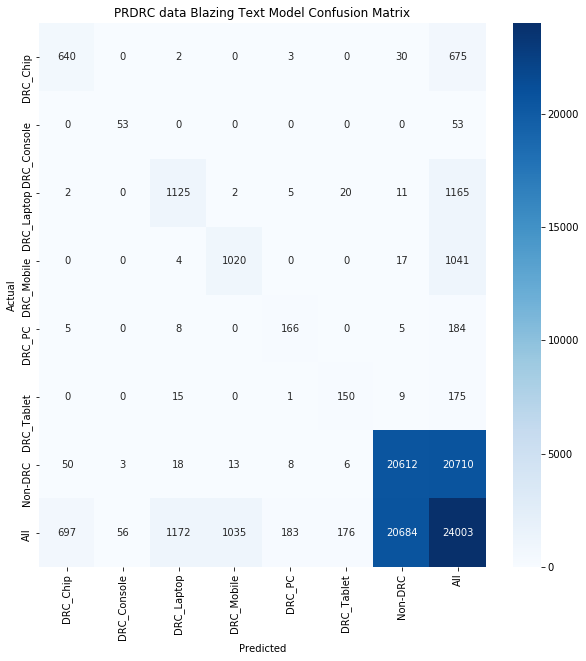

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(10,10))
plt.title("PRDRC data Blazing Text Model Confusion Matrix")
sns.heatmap(df_confusion,annot=True,fmt='',cmap='Blues');

In [57]:
from sklearn.metrics import classification_report
print("\t\tPRDRC - Blazing Text Model Classification Report\n",classification_report(pd.Series(labels),pd.Series(pred)))

		PRDRC - Blazing Text Model Classification Report
               precision    recall  f1-score   support

    DRC_Chip       0.92      0.95      0.93       675
 DRC_Console       0.95      1.00      0.97        53
  DRC_Laptop       0.96      0.97      0.96      1165
  DRC_Mobile       0.99      0.98      0.98      1041
      DRC_PC       0.91      0.90      0.90       184
  DRC_Tablet       0.85      0.86      0.85       175
     Non-DRC       1.00      1.00      1.00     20710

    accuracy                           0.99     24003
   macro avg       0.94      0.95      0.94     24003
weighted avg       0.99      0.99      0.99     24003



### Stop / Close the Endpoint (Optional)
Finally, we should delete the endpoint before we close the notebook if we don't need to keep the endpoint running for serving realtime predictions.

In [146]:
sess.delete_endpoint(text_classifier.endpoint)

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
